In [1]:
import torch
import os
import torch.nn as nn
from torchvision import transforms
from scipy.io import loadmat
import cv2 as cv
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import Dataset
import random
import gc
from torch.utils.data import DataLoader
from operator import itemgetter
import time
from torch.optim import Adam
import matplotlib.pyplot as plt
from utils import datasetprw as prw
import warnings
warnings.filterwarnings("ignore")

## HourGlass Moudule (HourGlassNet)

Creating a smaller version of the hourglass network (encoding/decoding network). The hourglass network is usually used in a stacked fashion. In the CenterNet Model (which is a Object Detection Algorithm/Architecture), they use a stacked hourglass network for feature extraction.

Below you can see how the HourGlass Module is being implemented. The Hourglass Module is based on the paper [Stacked Hourglass Networks for Human Estimation](https://arxiv.org/pdf/1603.06937.pdf) and we are using it to create an image that contains center keypoints. Center keypoints refers to the center of a bounding box drawn around a pedestrian. We use this architecture in essence to create a heatmap, which indicates regions which pedestrians are most likely to be.

We focus on a single HourGlass Module, which means that we use a single HourgGlass for the entire model. We chose to do this because our problem/task is much less complex than detecting human keypoints; hence we believe we won't need to use as many HourGlasses in the model. Therefore, in this case, the HourGlass Module is the Model/Network.

In [2]:
class ResNetBlock(nn.Module):
    """Creates a ResNet Block for feature extraction."""

    def __init__(self, inp_dim, out_dim):
        """Instantiates the Residual Module."""
        super(ResNetBlock, self).__init__()

        # half the output dimension.
        out = out_dim//2

        # sequence of layers (Batch Normalization, ReLu, Convolution)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = nn.Conv2d(inp_dim, out, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn2 = nn.BatchNorm2d(out)
        self.conv2 = nn.Conv2d(out, out, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(out)
        self.conv3 = nn.Conv2d(out, out_dim, kernel_size=1, stride=1, padding=0, bias=True)

        # add a skip layer for residual information
        self.skip_layer = nn.Conv2d(inp_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=True)
        self.need_skip = not (inp_dim == out_dim)

    def forward(self, x):
        """Defines a forward pass of the ResNet block."""

        # save residual information.
        residual = self.skip_layer(x) if self.need_skip else x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual

        return out

We use a recursive approach to generate the decoder/encoder layers in the model. This can be seen when creating the self.low2 layer.

In [3]:
class Hourglass(nn.Module):
    """Hourglass Module."""

    def __init__(self, n, filters, bn=None):
        """Creates an Hourglass Module/Network."""

        super(Hourglass, self).__init__()
        self.n = n
        # up-sampling data.
        self.up1 = ResNetBlock(filters, filters)
        # encoding/feature extraction.
        self.pool1 = nn.MaxPool2d(2, 2)
        self.low1 = ResNetBlock(filters, filters)
        # recursion to add more resnet blocks.
        self.low2 = Hourglass(n-1, filters, bn=bn) if self.n > 1 else ResNetBlock(filters, filters)
        self.low3 = ResNetBlock(filters, filters)
        # up-sampling data.
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        """Forward pass of the Hourglass Module."""

        up1  = self.up1(x)
        pool1 = self.pool1(x)
        # encoding (lower levels).
        low1 = self.low1(pool1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        up2  = self.up2(low3)

        # decoding (up-sampling).
        return up1 + up2

In [4]:
class HourGlassNetwork(nn.Module):
    """Creates an Hourglass Network."""

    def __init__(self, input_shape=(256, 256, 3), num_stack=1, num_heatmap=1):
        """Instantiates the network (we want single center key points.)"""

        super(HourGlassNetwork, self).__init__()

        # initial feature extraction layers.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.res1 = ResNetBlock(64, 128)
        self.pool = nn.MaxPool2d(2, 2)
        self.res2 = ResNetBlock(128, 128)
        self.res3 = ResNetBlock(128, 256)
        self.hg1 = Hourglass(4, 256)
        self.linear = nn.Conv2d(256, 256, kernel_size=1, padding=0, bias=True)
        self.bn2 = nn.BatchNorm2d(256)
        self.y = nn.Conv2d(256, num_heatmap, kernel_size=1, padding=0, bias=True)
        # additional sigmoid layer to keep values within 0 and 1.
        self.final = nn.Sigmoid()

    def forward(self, x):
        """Forward pass of the model."""

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.res1(out)
        out = self.pool(out)
        out = self.res2(out)
        out = self.res3(out)
        out = self.hg1(out)
        out = self.linear(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.y(out)
        out = self.final(out)

        return out

Create a Torch device to manage the data and the model.

In [5]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = torch.device('mps' if torch.has_mps else 'cuda' if torch.cuda.is_available() else 'cpu')

# create the model.
model = HourGlassNetwork()
model.to(DEVICE)
print('Device Set')

Device Set


Test an output of the Model.

In [6]:
img_path = r'/Users/chiahaohsutai/Documents/GitHub/PRW/images/frames/c1s1_000801.jpg'
image = cv.imread(img_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (256, 256))

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

process = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

img = process(image).unsqueeze(0).to(DEVICE)
img.shape

torch.Size([1, 3, 256, 256])

Run a prediction

In [7]:
# put the model in evalution mode.
model.eval()

with torch.no_grad():
    pred = model(img)

# get the shape of the output. 
pred.shape

torch.Size([1, 1, 64, 64])

Get a look at what the prediction looks like.

In [8]:
pred

tensor([[[[0.5225, 0.5261, 0.5303,  ..., 0.4700, 0.4671, 0.4664],
          [0.5265, 0.5275, 0.5306,  ..., 0.4686, 0.4676, 0.4653],
          [0.5360, 0.5356, 0.5460,  ..., 0.4718, 0.4726, 0.4731],
          ...,
          [0.4989, 0.4988, 0.5018,  ..., 0.4716, 0.4724, 0.4740],
          [0.5024, 0.4982, 0.5023,  ..., 0.4736, 0.4760, 0.4760],
          [0.5011, 0.5004, 0.5048,  ..., 0.4741, 0.4757, 0.4774]]]],
       device='mps:0')

In [9]:
flat_pred = torch.flatten(pred)
torch.mean(flat_pred)

tensor(0.4837, device='mps:0')

In [10]:
# example of squeezing the image to get a 64x64 output.
torch.squeeze(pred, (0, 1)).shape

torch.Size([64, 64])

Sigmoid Activation layer allows use to mantain the range of pixel intensities between 0-1, which will help us detemine peaks in the final output. A peak would be a pixel with intensity 1.

Now look at the annotations and boxes for the image. Get the centers for each pedestrian in the image.

In [11]:
# load in the annotations.
ann_path = r'/Users/chiahaohsutai/Documents/GitHub/PRW/annotations/c1s1_000801.jpg.mat'
annotation = loadmat(ann_path)['box_new']
annotation = [ann[1:] for ann in annotation]

In [12]:
# calculate the centers.
centers = []
for ann in annotation:
    x, y, w, h = ann
    centers.append((x+(w/2), y+(h/2)))

Run the cell below as code if you want to see the centers being drawn in the image. The centers are red dots and they are pretty small.

In [13]:
im = Image.open(img_path)

Now we are going to focus on training and learning. We need to create a Gaussian Patch to help the model learn. Otherwise the model might have a hard time predicting the center.

In [14]:
def generate_patch(scale=12):
    """Creates a heatmap using Gaussian Distribution."""

    # constants.
    sigma = 1

    size = 6 * sigma + 1
    x_mesh, y_mesh = torch.meshgrid(torch.arange(0, 6*sigma+1, 1), torch.arange(0, 6*sigma+1, 1), indexing='xy')

    # the center of the gaussian patch should be 1
    center_x = size // 2
    center_y = size // 2

    # generate this 7x7 gaussian patch
    xmesh = torch.square(torch.sub(x_mesh, center_x))
    ymesh = torch.square(torch.sub(y_mesh, center_y))
    denom = (sigma**2) * 2
    gaussian_patch = torch.mul(torch.exp(torch.div(torch.neg(torch.add(xmesh, ymesh)), denom)), scale)

    return gaussian_patch

Display what the Gaussian Patch looks like.

In [15]:
w, h = im.size
x, y = centers[0]
patch = generate_patch(1)
torch.Tensor.numpy(patch)

array([[1.2340980e-04, 1.5034392e-03, 6.7379470e-03, 1.1108996e-02,
        6.7379470e-03, 1.5034392e-03, 1.2340980e-04],
       [1.5034392e-03, 1.8315639e-02, 8.2084998e-02, 1.3533528e-01,
        8.2084998e-02, 1.8315639e-02, 1.5034392e-03],
       [6.7379470e-03, 8.2084998e-02, 3.6787945e-01, 6.0653067e-01,
        3.6787945e-01, 8.2084998e-02, 6.7379470e-03],
       [1.1108996e-02, 1.3533528e-01, 6.0653067e-01, 1.0000000e+00,
        6.0653067e-01, 1.3533528e-01, 1.1108996e-02],
       [6.7379470e-03, 8.2084998e-02, 3.6787945e-01, 6.0653067e-01,
        3.6787945e-01, 8.2084998e-02, 6.7379470e-03],
       [1.5034392e-03, 1.8315639e-02, 8.2084998e-02, 1.3533528e-01,
        8.2084998e-02, 1.8315639e-02, 1.5034392e-03],
       [1.2340980e-04, 1.5034392e-03, 6.7379470e-03, 1.1108996e-02,
        6.7379470e-03, 1.5034392e-03, 1.2340980e-04]], dtype=float32)

Display it as an image.

The Gaussian Patch is being created properly as seen by the output tensor after converting from img to tensor. Now we should try to figure out how to place the patch in the heatmap.

In [16]:
def make_heatmap(width, height, center_x, center_y, gau_patch):
    """Places a Gaussian Patch in the heatmap."""

    # constants.
    heatmap = np.zeros((height, width))
    sigma = 1
    visibility = 2
    gau_patch = torch.Tensor.numpy(gau_patch)

    # this gaussian patch is 7x7, let's get four corners of it first
    xmin = center_x - 3 * sigma
    ymin = center_y - 3 * sigma
    xmax = center_x + 3 * sigma
    ymax = center_y + 3 * sigma
    
    # if outside the image don't include the gaussian patch.
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    # determine boundaries for patch if outside the image.
    patch_xmin = max(0, -xmin)
    patch_ymin = max(0, -ymin)
    patch_xmax = min(xmax, width) - xmin
    patch_ymax = min(ymax, height) - ymin
    
    # we need to determine where to put this patch in the whole heatmap
    heatmap_xmin = max(0, xmin)
    heatmap_ymin = max(0, ymin)

    for j in range(patch_ymin, patch_ymax):
        for i in range(patch_xmin, patch_xmax):
            heatmap[j+heatmap_ymin, i+heatmap_xmin] = gau_patch[j, i]

    return torch.FloatTensor(heatmap)

Before generating the final image for training (aka the heatmap), we are going to preprocess the data. To a 64x64 image which would be equivalent to the output shape of the HourGlass Model.

In [17]:
rx, ry = 64/w, 64/h

# re-locate the centers for the new image dimensions.
resized_centers = []
for center in centers:
    cx, cy = center
    resized_centers.append((cx*rx, cy*ry))

In [18]:
x_pos, y_pos = resized_centers[0]
heatmap_example = make_heatmap(64, 64, int(x_pos), int(y_pos), patch)
heatmap_example[int(y_pos)][int(x_pos)]

tensor(1.)

The patch was added since the center of the pedestrian has value 1. Run the code below if you want a visualization of the heatmap.

Now we need to create a function that will generate the appropiate set of heatmaps for multiple pedestrians in a single image.

In [19]:
def make_heatmap_plural(width, height, keypoints, gau_patch):
    """Places a Gaussian Patch in the heatmap."""

    # constants.
    heatmap = np.zeros((height, width))
    sigma = 1
    visibility = 2
    gau_patch = torch.Tensor.numpy(gau_patch)

    # generates the limits of the patch for each keypoint.
    coordinates = []
    for keypoint in keypoints:
        center_x, center_y = keypoint
        
        # get the coordinates.
        xmin = center_x - 3 * sigma
        ymin = center_y - 3 * sigma
        xmax = center_x + 3 * sigma
        ymax = center_y + 3 * sigma
        coordinates.append((xmin, ymin, xmax, ymax))

    # for each keypoint draw the patch.
    for coordinate in coordinates:
        # unpack the coordinates.
        xmin, ymin, xmax, ymax = coordinate

        # if outside the image don't include the patch.
        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            pass

        # determine boundaries for patch if outside the image.
        patch_xmin = max(0, -xmin)
        patch_ymin = max(0, -ymin)
        patch_xmax = min(xmax, width) - xmin
        patch_ymax = min(ymax, height) - ymin

        # we need to determine where to put this patch in the whole heatmap
        heatmap_xmin = int(max(0, xmin))
        heatmap_ymin = int(max(0, ymin))

        # add the patches to the image.
        for j in range(int(patch_ymin), int(patch_ymax)):
            for i in range(int(patch_xmin), int(patch_xmax)):
                
                # get the value within the patch.
                gau_pixel = gau_patch[j, i]
                pixel = heatmap[j+heatmap_ymin, i+heatmap_xmin]
                
                # if the pixel already has a value assigned to it take the max.
                if pixel > 0:
                    heatmap[j+heatmap_ymin, i+heatmap_xmin] = max(pixel, gau_pixel)
                else:
                    heatmap[j+heatmap_ymin, i+heatmap_xmin] = gau_pixel

    # return the final heatmap as a tensor.
    return torch.FloatTensor(heatmap)

Now we will create a heatmap which includes all the pedestrians within the image.

In [20]:
# create a new patch
patch = generate_patch(1)
sample_heatmap = make_heatmap_plural(64, 64, resized_centers, patch)
sample_heatmap

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

To display the heatmap convert the cell below to a code cell and run.

Now we will create the Torch dataset and load it. Then we will train the model and look at some results.

In [21]:
class PrwHeatMaps(Dataset):
    """Creates a custom dataset with the PRW data."""

    def __init__(self, img_path, ann_path, indexes, transform=None, resize_shape=(64, 64)):
        """Instantiates the dataset."""

        # setup transforms
        self.transform = transform
        self.resize_shape = resize_shape

        # set up img and annotations paths.
        self.img_path = img_path
        self.ann_path = ann_path

        # get all image and annotations.
        self.img_names = sorted(list(os.listdir(img_path)))
        self.ann_names = sorted(list(os.listdir(ann_path)))
        
        # get the given index range. (This is for train/testing)
        self.img_names = itemgetter(*indexes)(self.img_names)
        self.ann_names = itemgetter(*indexes)(self.ann_names)
        
        # create a patch.
        self.patch = generate_patch(1)

        # check that the annotations and images match.
        if len(self.img_names) != len(self.ann_names):
            raise ValueError("Images and annotations don't align")
        for img, ann in zip(self.img_names, self.ann_names):
            name, _ = os.path.splitext(img)
            if name not in ann:
                raise ValueError("Image and annotation names don't align")

    def _get_ann(self, name):
        """Loads in the annotation and gets the bounding boxes."""

        # load in the annotation.
        name = os.path.join(self.ann_path, name)
        ann = loadmat(name)
        if 'box_new' in ann.keys():
            ann = ann['box_new']
        elif 'anno_file' in ann.keys():
            ann = ann['anno_file']
        else:
            raise ValueError("Invalid Annotation Error")
            
        # remove the first value of each set of bounding boxes.
        ann = [a[1:] for a in ann]

        centers = list()
        # calculate the center of the bounding box.
        for a in ann:
            # unpack the annotation.
            x, y, w, h = a
            centers.append((x+(w/2), y+(h/2)))

        return centers

    def _get_img(self, name):
        """Loads in an image."""

        name = os.path.join(self.img_path, name)
        photo = cv.cvtColor(cv.imread(name), cv.COLOR_BGR2RGB)
        height, width = photo.shape[0], photo.shape[1]

        return photo, width, height

    def __len__(self):
        """Returns the total number of samples"""

        return len(self.img_names)

    def __getitem__(self, index):
        """Returns one sample of the data."""

        # get the image and the corresponding annotation.
        img, width, height = self._get_img(self.img_names[index])
        ann = self._get_ann(self.ann_names[index])
        count = len(ann)

        # convert the annotation to tensor.
        # ann = torch.FloatTensor(ann)

        # apply transform if available.
        if self.transform:
            # get the center of mass.
            rx, ry = self.resize_shape[0]/width, self.resize_shape[1]/height
            ann = [(a[0]*rx, a[1]*ry) for a in ann]

            # create the patch and the heatmap.
            heat = make_heatmap_plural(self.resize_shape[0],
                                       self.resize_shape[1],
                                       ann, 
                                       self.patch)

            return self.transform(img), heat, count

        return img, ann, count

In [22]:
# mean and std was calculated in another notebook. 
MEAN = [0.5062, 0.5004, 0.4894]
STD = [0.1942, 0.1879, 0.1980]

# create the transform.
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# create the dataset.
data = PrwHeatMaps(r'/Users/chiahaohsutai/Documents/GitHub/PRW/images/frames',
                   r'/Users/chiahaohsutai/Documents/GitHub/PRW/annotations', 
                   list(range(0, 10)), preprocess)

We will look at a single datapoint and what it consists of. It should be an image as a tensor and a heatmap as a tensor.

In [23]:
# get a look at a datapoint
data[0]

(tensor([[[ 2.5427,  2.5427,  2.5225,  ...,  0.0791,  0.1195,  0.0993],
          [ 2.5427,  2.5427,  2.5225,  ...,  0.0791,  0.0388,  0.0589],
          [ 2.5427,  2.5427,  2.5225,  ...,  0.0589,  0.0186, -0.0218],
          ...,
          [ 0.0388,  0.0589,  0.0186,  ..., -0.8700, -0.7488, -0.7690],
          [ 0.0186,  0.0388, -0.0420,  ..., -0.7488, -0.7690, -0.7690],
          [-0.0824, -0.1026, -0.1632,  ..., -0.8700, -0.7892, -0.7488]],
 
         [[ 2.6589,  2.6589,  2.6380,  ...,  0.1127,  0.1544,  0.1335],
          [ 2.6589,  2.6589,  2.6380,  ...,  0.1127,  0.0709,  0.0918],
          [ 2.6589,  2.6589,  2.6380,  ...,  0.0918,  0.0500,  0.0083],
          ...,
          [-0.0126, -0.0126,  0.0083,  ..., -0.9100, -0.8056, -0.9100],
          [-0.0126,  0.0292, -0.0126,  ..., -0.8056, -0.8265, -0.8683],
          [-0.0960, -0.0960, -0.1378,  ..., -0.9100, -0.8683, -0.8265]],
 
         [[ 2.5788,  2.5788,  2.5590,  ...,  0.1625,  0.2021,  0.1823],
          [ 2.5788,  2.5788,

Run the cell below to get a look at the heatmap. The image itself is resized and the channel intensities are standardized using the Datasets mean and standard deviation. The heatmap is the same as in the tests above.

In [24]:
data[0][1].shape

torch.Size([64, 64])

Now we will create a train test split for out model. Given how the data is loading into torch we need to create a list of indexes that will serve as training and testing. We also test to see if the indexes did indeed change, python cell should print false.

In [25]:
# get image directory length.
num_images = len(os.listdir(r'/Users/chiahaohsutai/Documents/GitHub/PRW/images/frames'))

# generate all possible indexes and shuffle them.
indexes = list(range(num_images))
indexes_2 = list(range(num_images))
random.seed(13)
random.shuffle(indexes)
print(indexes == indexes_2)

# delete and collect.
del indexes_2
gc.collect()

False


0

We are going to use a 70/30 split. So we will get the first 70% of the indexes and the use the rest for testing.

In [26]:
# get 80% of the total number of image and split.
max_id = int(num_images * 0.7)
train_idx = indexes[:max_id]
test_idx = indexes[max_id:]
print(f'TrainingSet Size: {len(train_idx)}, TestingSet Size: {len(test_idx)}')

TrainingSet Size: 8271, TestingSet Size: 3545


This might not be enough data to train a fully functional model. But we will see after training. Next we will be creating the data loaders and setting some of the parameters. You might notice the use of prw.PrwHeatMaps(...), multiprocessing was having issues with Jupyter and how it uses mutiple workers in a multi thread process; hence, the custom dataset was moved to a Python file and imported into the notebook. This fixed the issue.

In [27]:
# get the paths to the data.
images_path = r'/Users/chiahaohsutai/Documents/GitHub/PRW/images/frames'
annota_path = r'/Users/chiahaohsutai/Documents/GitHub/PRW/annotations'
batch = 32

# create the datasets.
train_set = prw.PrwHeatMaps(images_path, annota_path, train_idx, preprocess)
test_set = prw.PrwHeatMaps(images_path, annota_path, test_idx, preprocess)

# create data loaders
trainLoader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=os.cpu_count())
testLoader = DataLoader(test_set, batch_size=batch, num_workers=os.cpu_count())

For the loss function we will use Mean Error Squared as in the paper [Stacked Hourglass Networks for Human Estimation](https://arxiv.org/pdf/1603.06937.pdf). As mentioned earlier, we do add a Gaussian Patch to the images, which should go well with using Mean Error Squared as the loss function. The Gaussian Patch draws a region of interest, so we can mesure how off (using MSE) are the intesities in the output of the model. We use Adam optimizer for our cost minimization algorithm.

In [28]:
# set the learning rate.
LR = 0.0001

# calculate steps per epoch for training and validation set
trainSteps = len(train_set) // batch
valSteps = len(test_set) // batch

# set the loss and optimizer.
loss_fn = nn.MSELoss()
opt = Adam(model.parameters(), lr=LR)

We should have an instance of the HourGlass Model from earlier. Lets put that in train mode and set up the required train loss informormation. We are also going to add a few keys in a diuctionary to track error. One of those errors will be the pedestrian count in the image. Since we are looking at heatmap. we are just going to get the peaks within the image and compare. 

This next cell is the complete training and validation loop. Since we are using a Custom Dataset and loss function, we need to manually generate the loop and the training. 

In [31]:
epochs = 10

# create a dictionary that stores the training loss.
H = {"total_train_loss": [], "total_val_loss": [], 
     "total_train_acc": [], "total_validation_acc": []}

# indicate training.
print("[INFO] training the network...")

# record current time for total training time later.
startTime = time.time()

# loop over epochs
for e in range(epochs):
    
    # set the model in training mode
    model.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    
    # loop over the training set
    for img, truth_map, count in trainLoader:
        # send the input to the device
        img, truth_map = img.to(DEVICE), truth_map.to(DEVICE)
        
        
        # perform a forward pass and calculate the training loss
        predictions = model(img)
        loss = loss_fn(predictions, truth_map)
        totalLoss = loss
        
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()
        
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += totalLoss
        
        flat_count = torch.flatten(predictions.detach(), start_dim=1)
        for idx in range(flat_count.shape[0]):
            
            # get the count for the tensor and add to acc. count.
            pred_count = torch.sum(flat_count[idx] >= 0.90)
            if (pred_count - count[idx]) == 0:
                trainCorrect += 1
    
    # switch off autograd
    with torch.no_grad():
        
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for img, truth_map, count in testLoader:
            
            # send the input to the device
            img, truth_map = img.to(DEVICE), truth_map.to(DEVICE)
            
            # make the predictions and calculate the validation loss
            predictions = model(img)
            loss = loss_fn(predictions, truth_map)
            totalLoss = loss
            totalValLoss += totalLoss
            
            flat_count = torch.flatten(predictions.detach(), start_dim=1)
            for idx in range(flat_count.shape[0]):

                # get the count for the tensor and add to acc. count.
                pred_count = torch.sum(flat_count[idx] >= 0.90)
                if (pred_count - count[idx]) == 0:
                    valCorrect += 1
    
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(train_set)
    valCorrect = valCorrect / len(test_set)
    
    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["total_train_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["total_validation_acc"].append(valCorrect)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
    
# print out the time it took for the epoch to train.
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.002647, Train accuracy: 0.0000
Val loss: 0.002588, Val accuracy: 0.0000
[INFO] EPOCH: 2/10
Train loss: 0.002645, Train accuracy: 0.0000
Val loss: 0.002587, Val accuracy: 0.0000
[INFO] EPOCH: 3/10
Train loss: 0.002646, Train accuracy: 0.0000
Val loss: 0.002587, Val accuracy: 0.0000
[INFO] EPOCH: 4/10
Train loss: 0.002645, Train accuracy: 0.0000
Val loss: 0.002586, Val accuracy: 0.0000
[INFO] EPOCH: 5/10
Train loss: 0.002644, Train accuracy: 0.0000
Val loss: 0.002585, Val accuracy: 0.0000
[INFO] EPOCH: 6/10
Train loss: 0.002645, Train accuracy: 0.0000
Val loss: 0.002586, Val accuracy: 0.0000
[INFO] EPOCH: 7/10
Train loss: 0.002643, Train accuracy: 0.0000
Val loss: 0.002588, Val accuracy: 0.0000
[INFO] EPOCH: 8/10
Train loss: 0.002644, Train accuracy: 0.0000
Val loss: 0.002585, Val accuracy: 0.0000
[INFO] EPOCH: 9/10
Train loss: 0.002642, Train accuracy: 0.0000
Val loss: 0.002585, Val accuracy: 0.0000
[INFO] EPOCH: 10/10
Trai

Model is predicting close to 0 for all pixels in the image. I think this is an issue with the loss function. If the model predicts 0 for most pixels it essentially reduces the error by a large degree, since most pixels have value 0 the heatmap.

In [46]:
for i in range(25):
    print(torch.div(torch.sum(predictions[i].detach()), 64*64))

tensor(0.0060, device='mps:0')
tensor(0.0058, device='mps:0')
tensor(0.0059, device='mps:0')
tensor(0.0061, device='mps:0')
tensor(0.0061, device='mps:0')
tensor(0.0060, device='mps:0')
tensor(0.0063, device='mps:0')
tensor(0.0059, device='mps:0')
tensor(0.0059, device='mps:0')
tensor(0.0061, device='mps:0')
tensor(0.0065, device='mps:0')
tensor(0.0060, device='mps:0')
tensor(0.0060, device='mps:0')
tensor(0.0059, device='mps:0')
tensor(0.0062, device='mps:0')
tensor(0.0060, device='mps:0')
tensor(0.0061, device='mps:0')
tensor(0.0062, device='mps:0')
tensor(0.0059, device='mps:0')
tensor(0.0062, device='mps:0')
tensor(0.0061, device='mps:0')
tensor(0.0061, device='mps:0')
tensor(0.0061, device='mps:0')
tensor(0.0060, device='mps:0')
tensor(0.0059, device='mps:0')


[INFO] saving object detector model...


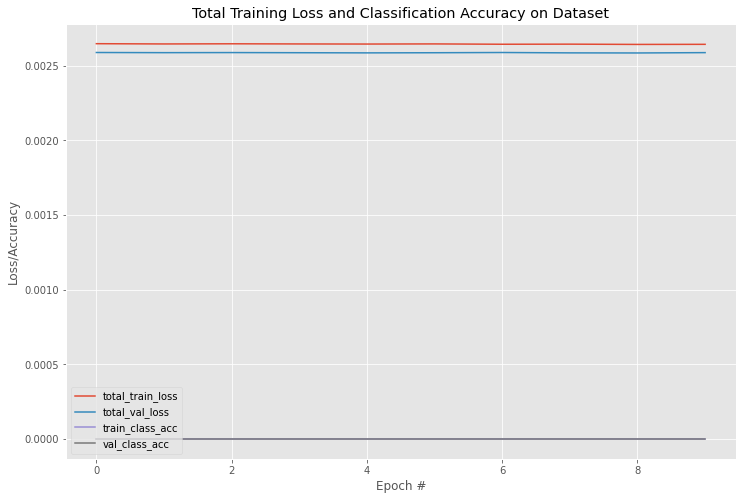

In [42]:
# path to current folder.
curr_dir = r'/Users/chiahaohsutai/Documents/GitHub/PedestrianDetection/save'
model_dir = os.path.join(curr_dir, 'model.pth')

# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(model, model_dir)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["total_train_acc"], label="train_class_acc")
plt.plot(H["total_validation_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# save the training plot
plotPath = os.path.sep.join([curr_dir, "training.png"])
plt.savefig(plotPath)

# show the plot.
plt.show()

The current model is not learning. I think the model is predicting 0 for all values.